In [10]:
import mne

In [11]:
import pandas as pd

In [12]:
import json

In [13]:
# %matplotlib inline
import matplotlib.pyplot as plt

In [14]:
import numpy as np

In [116]:
%matplotlib inline

In [15]:
import matplotlib

In [16]:
%load_ext autoreload

%autoreload 2
import tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import datetime as dt

In [18]:
import eeg_events

# Обнаружение попыток с артефактами

In [37]:
baseline_raw = mne.io.read_raw_fif("./valid-data/processed/test-filtered-unprocessed.raw.fif", preload=True)

Opening raw data file ./valid-data/processed/test-filtered-unprocessed.raw.fif...
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.
Reading 0 ... 108903  =      0.000 ...   425.402 secs...


In [39]:
events_df = pd.read_csv("./valid-data/processed/events-test-filtered.csv")

In [38]:
_ = mne.viz.plot_raw(
    baseline_raw,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)

In [88]:
# TODO code for adding stim channel
# sfreq = baseline_raw.info["sfreq"]

# eeg_data = baseline_raw.get_data()

# stim_channel = np.zeros(eeg_data.shape[1])

# timestamps = (events_df["timestamp"] * sfreq).astype(int)

# stim_channel[timestamps[timestamps < stim_channel.shape[0]]] = 1

# stim_raw = mne.io.RawArray([stim_channel], stim_signal_info)

# baseline_raw.add_channels([stim_raw])

# # mne.Epochs

- Удалить бэды через mne.Epochs(...)
- Применить ica
- Найдете компоненты и удалите (ica.apply, ica.exclude)
- Удалить бэды через mne.Epochs(...) для фильтрованного

In [95]:
# _ = mne.viz.plot_raw(
#     ica_eeg,
#     duration=30, 
#     start=0, 
#     scalings=5,
#     show=True
# )

In [93]:
%matplotlib inline

In [94]:
raw_part = baseline_raw.copy().crop(tmin=15, tmax=50)

# Первые секунды исходного сигнала

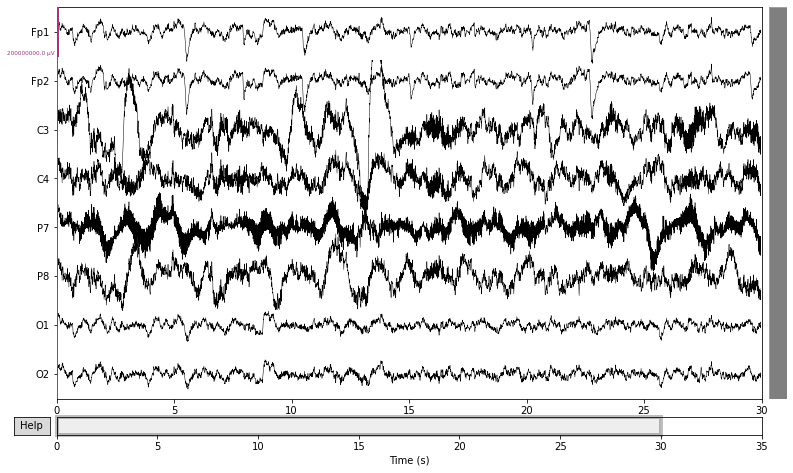

In [95]:
_ = mne.viz.plot_raw(
    raw_part,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)

# Визуализация ICA компонент

In [96]:
ica = mne.preprocessing.ICA()

In [97]:
ica.fit(raw_part.copy())

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting all PCA components: 8 components
Fitting ICA took 0.8s.


<ICA | raw data decomposition, fit (fastica): 8961 samples, 8 components, channels used: "eeg">

In [98]:
ica_eeg = ica.get_sources(raw_part)

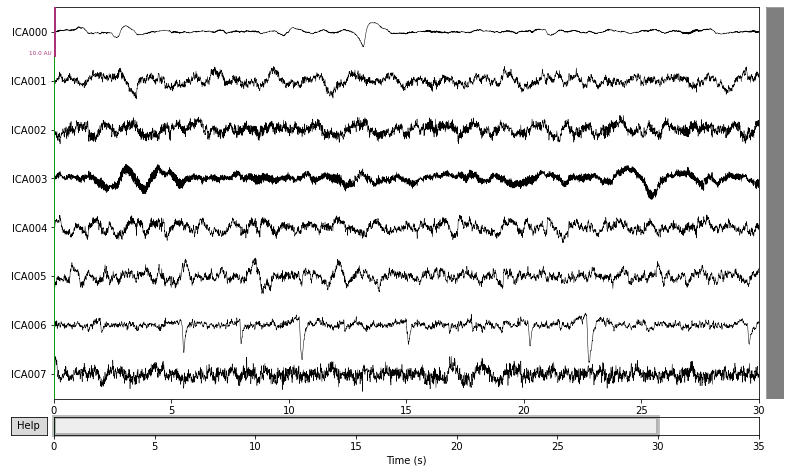

In [99]:
_ = mne.viz.plot_raw(
    ica_eeg,
    duration=30, 
    start=0, 
    scalings=5,
    show=True
)

# Выбор попыток для обнаружения артефактов

В качестве грязной попытки выбираем 5-10 секунды компоненты 6. В качестве чистой - то же для 7

In [107]:
ica_df = pd.DataFrame(ica_eeg.get_data().T, columns=ica_eeg.info.ch_names)

In [108]:
_, time = ica_eeg[:]

In [109]:
ica_df["time"] = time

In [110]:
trial_dirty = ica_df[
    (ica_df["time"] > 5) & (ica_df["time"] < 10)
]["ICA006"]

In [117]:
trial_clean = ica_df[
    (ica_df["time"] > 5) & (ica_df["time"] < 10)
]["ICA007"]

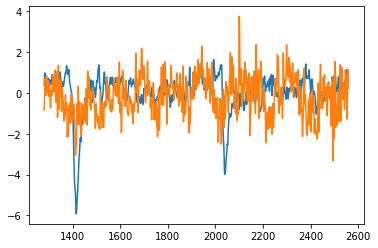

In [118]:
plt.plot(trial_dirty)
plt.plot(trial_clean)

# Оценка местоположения

In [145]:
components = ica.get_components()

In [172]:
map_df = pd.DataFrame(ica.get_components(), index=baseline_raw.ch_names, columns=ica_eeg.ch_names)

Компонента 6 опирается на фронтальные электроды - она может соответствовать морганиям

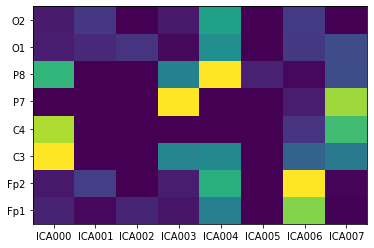

In [173]:
plt.pcolor(map_df, vmin=0, vmax=np.quantile(components, 0.95))
plt.yticks(np.arange(0.5, len(map_df.index), 1), map_df.index)
plt.xticks(np.arange(0.5, len(map_df.columns), 1), map_df.columns)
plt.show()

# Оценка спектра

In [122]:
dirty_spectre = np.abs(np.fft.fft(trial_dirty, n=256))[1:256//2]
clean_spectre = np.abs(np.fft.fft(trial_clean, n=256))[1:256//2]

Для грязной попытки (моргания) частоты с 1 по 3 будут преобладать в сигнале, по сравнению с чистой попыткой

(-0.1, 30.0)

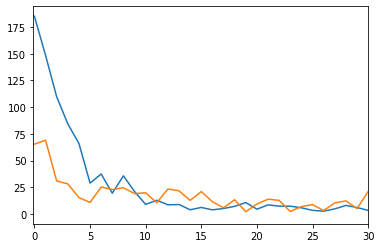

In [123]:
plt.plot(dirty_spectre)
plt.plot(clean_spectre)
plt.xlim(-0.1, 30)

# Эксцесс

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,
          1.,   7.,  11.,  30.,  34.,  67.,  81., 107., 139., 133., 139.,
        142., 124.,  98.,  69.,  51.,  19.,  12.]),
 array([-6.        , -5.72413793, -5.44827586, -5.17241379, -4.89655172,
        -4.62068966, -4.34482759, -4.06896552, -3.79310345, -3.51724138,
        -3.24137931, -2.96551724, -2.68965517, -2.4137931 , -2.13793103,
        -1.86206897, -1.5862069 , -1.31034483, -1.03448276, -0.75862069,
        -0.48275862, -0.20689655,  0.06896552,  0.34482759,  0.62068966,
         0.89655172,  1.17241379,  1.44827586,  1.72413793,  2.        ]),
 <a list of 29 Patch objects>)

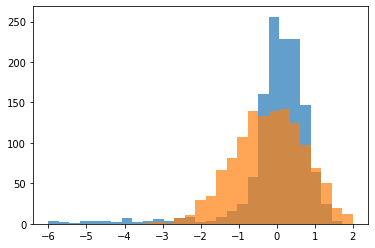

In [125]:
plt.hist(trial_dirty, bins=np.linspace(-6, 2, 30), alpha=0.7)
plt.hist(trial_clean, bins=np.linspace(-6, 2, 30), alpha=0.7)

In [126]:
from scipy import stats

Коэффициент эксцесса будет больше для грязной попытки, т.к. пик распределения более выражен

In [127]:
stats.kurtosis(trial_dirty), stats.kurtosis(trial_clean)

(12.04688720003896, 0.08205010488422904)

# Удаление артефактов из попытки

In [128]:
transformed_raw = ica.apply(raw_part.copy(), exclude=[0, 6])

Transforming to ICA space (8 components)
Zeroing out 2 ICA components


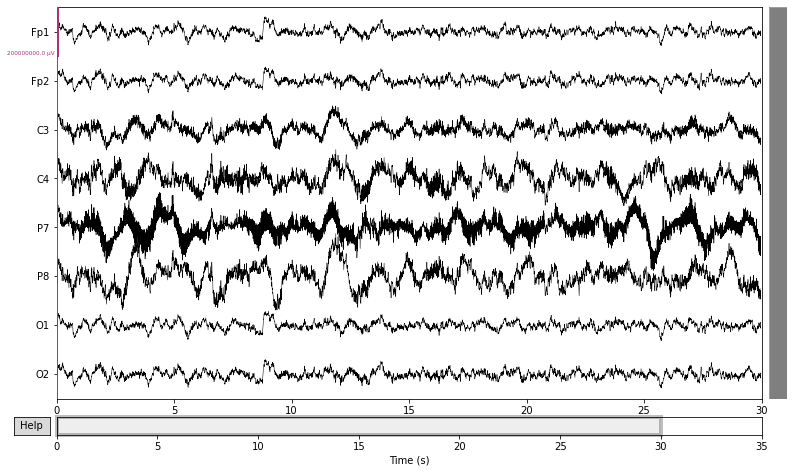

In [129]:
_ = mne.viz.plot_raw(
    transformed_raw,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)